In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm

In [2]:
DATA_PATH = "./logs/EuroSAT_logs/run7_epochs_100"
DATASET = "EuroSAT"
MODEL_NAME = "ResNet50"
NUM_EXPERIENCES = 5
valid_colors = ['green', 'red', 'cyan', 'magenta', 'black', 'purple', 'orange', 'brown', 'gray', 'olive', 'indigo', 'turquoise']

In [3]:
# all combinations of training
run2name = {
    "n_nst_npp" : "Naive_NoSelfTraining_NoPostProcessing",
    "n_st_npp" : "Naive_SelfTraining_NoPostProcessing",
    "n_nst_pp_ts" : "Naive_NoSelfTraining_PostProcessing_TemperatureScaling",
    "n_nst_pp_ts_md" : "Naive_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData",
    "n_nst_pp_vs" : "Naive_NoSelfTraining_PostProcessing_VectorScaling",
    "n_nst_pp_vs_md" : "Naive_NoSelfTraining_PostProcessing_VectorScaling_MixedData",
    "n_nst_pp_ms" : "Naive_NoSelfTraining_PostProcessing_MatrixScaling",
    "n_nst_pp_ms_md" : "Naive_NoSelfTraining_PostProcessing_MatrixScaling_MixedData",

    "r_nst_npp" : "Replay_NoSelfTraining_NoPostProcessing",
    "r_st_npp" : "Replay_SelfTraining_NoPostProcessing",
    "r_nst_pp_ts" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling",
    "r_nst_pp_ts_md" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData",
    "r_nst_pp_vs" : "Replay_NoSelfTraining_PostProcessing_VectorScaling",
    "r_nst_pp_vs_md" : "Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData",
    "r_nst_pp_ms" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling",
    "r_nst_pp_ms_md" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData",
    
    "j_nst_npp" : "JointTraining_NoSelfTraining_NoPostProcessing",
    "j_st_npp" : "JointTraining_SelfTraining_NoPostProcessing",
    "j_nst_pp_ts" : "JointTraining_NoSelfTraining_PostProcessing_TemperatureScaling",
    "j_nst_pp_vs" : "JointTraining_NoSelfTraining_PostProcessing_VectorScaling",
    "j_nst_pp_ms" : "JointTraining_NoSelfTraining_PostProcessing_MatrixScaling",
}

In [4]:
run2label = {
    "n_nst_npp" : "Naive_NoSelfTraining_NoPostProcessing",
    "n_st_npp" : "Naive_SelfTraining_NoPostProcessing",
    "n_nst_pp_ts" : "Naive_NoSelfTraining_PostProcessing_TemperatureScaling",
    "n_nst_pp_ts_md" : "Naive_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData",
    "n_nst_pp_vs" : "Naive_NoSelfTraining_PostProcessing_VectorScaling",
    "n_nst_pp_vs_md" : "Naive_NoSelfTraining_PostProcessing_VectorScaling_MixedData",
    "n_nst_pp_ms" : "Naive_NoSelfTraining_PostProcessing_MatrixScaling",
    "n_nst_pp_ms_md" : "Naive_NoSelfTraining_PostProcessing_MatrixScaling_MixedData",

    "r_nst_npp" : "Replay_NoSelfTraining_NoPostProcessing",
    "r_st_npp" : "Replay_SelfTraining_NoPostProcessing",
    "r_nst_pp_ts" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling",
    "r_nst_pp_ts_md" : "Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData",
    "r_nst_pp_vs" : "Replay_NoSelfTraining_PostProcessing_VectorScaling",
    "r_nst_pp_vs_md" : "Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData",
    "r_nst_pp_ms" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling",
    "r_nst_pp_ms_md" : "Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData",
    
    "j_nst_npp" : "JointTraining_NoSelfTraining_NoPostProcessing",
    "j_st_npp" : "JointTraining_SelfTraining_NoPostProcessing",
    "j_nst_pp_ts" : "JointTraining_NoSelfTraining_PostProcessing_TemperatureScaling",
    "j_nst_pp_vs" : "JointTraining_NoSelfTraining_PostProcessing_VectorScaling",
    "j_nst_pp_ms" : "JointTraining_NoSelfTraining_PostProcessing_MatrixScaling",
}

In [5]:
running_accuracy = []
running_ece = []
final_accuracy = []
final_ece = []
bins = None
ece_hist_vals = []

for k, name in run2name.items():
    print(f">> {name} <<")
    with open(f"{DATA_PATH}/{DATASET}_{MODEL_NAME}_{name}_dict", "rb") as file:
        data = pickle.load(file)

        # print("\n---- ACCURACY ----")

        metric_str = "Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_acc = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_acc += cur_exp_dict[metric_str + f"{j:03d}"]
            m.append(cur_exp_acc/(i+1))
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_accuracy.append((k, m))
        final_accuracy.append((k, running_accuracy[-1][-1][-1]))
        # print(k, m, running_accuracy[-1][-1][-1])

        # print("\n---- ECE ----")

        metric_str = "ECE_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_ece = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_ece += cur_exp_dict[metric_str + f"{j:03d}"]
            m.append(cur_exp_ece/(i+1))
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_ece.append((k, m))
        final_ece.append((k, running_ece[-1][-1][-1]))
        # print(k, m, running_ece[-1][-1][-1])

        # print("\n---- ECE HISTOGRAMS ----")

        metric_str = "ExpECEHistogram/eval_phase/test_stream/Exp"
        m = []
        i = -1 # after last experience
        cur_exp_dict = data[i]
        for j in range(NUM_EXPERIENCES):
            # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
            fig = cur_exp_dict[metric_str + f"{j:03d}"]
            axes_list = fig.get_axes()
            for ax in axes_list:
                for line in ax.get_lines()[-1:]:
                    x_data = line.get_xdata()
                    y_data = line.get_ydata()
                    # print({'x': x_data, 'y': y_data})
                    if bins is None:
                        bins = x_data
                    m.append(y_data)
        # print(bins, m)
        bin_vals = []
        for i in range(len(bins)):
            x = []
            for j in range(len(m)):
                # print(j, i, m[j][i])
                x.append(m[j][i])
            mean = np.mean(x)
            std = np.std(x)
            bin_vals.append((mean, std))
        # print(k, bin_vals)
        ece_hist_vals.append((k, bin_vals))


>> Naive_NoSelfTraining_NoPostProcessing <<
>> Naive_SelfTraining_NoPostProcessing <<
>> Naive_NoSelfTraining_PostProcessing_TemperatureScaling <<
>> Naive_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData <<
>> Naive_NoSelfTraining_PostProcessing_VectorScaling <<
>> Naive_NoSelfTraining_PostProcessing_VectorScaling_MixedData <<
>> Naive_NoSelfTraining_PostProcessing_MatrixScaling <<
>> Naive_NoSelfTraining_PostProcessing_MatrixScaling_MixedData <<
>> Replay_NoSelfTraining_NoPostProcessing <<
>> Replay_SelfTraining_NoPostProcessing <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling <<
>> Replay_NoSelfTraining_PostProcessing_TemperatureScaling_MixedData <<
>> Replay_NoSelfTraining_PostProcessing_VectorScaling <<
>> Replay_NoSelfTraining_PostProcessing_VectorScaling_MixedData <<
>> Replay_NoSelfTraining_PostProcessing_MatrixScaling <<
>> Replay_NoSelfTraining_PostProcessing_MatrixScaling_MixedData <<
>> JointTraining_NoSelfTraining_NoPostProcessing <<
>> JointTraining

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


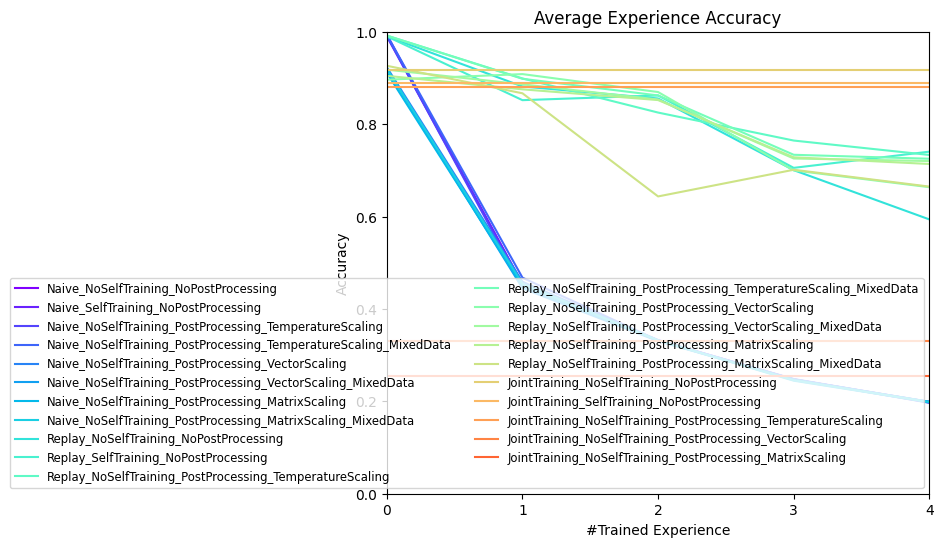

In [6]:
# PLOT 1: Average accuracy on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(NUM_EXPERIENCES))
color = iter(cm.rainbow(np.linspace(0, 1, 24)))
for i, (name, vals) in enumerate(running_accuracy):
    c = next(color)
    plt.plot(x_axis, vals, label=run2label[name], color=c)
plt.title('Average Experience Accuracy')
plt.xlabel('#Trained Experience')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, NUM_EXPERIENCES-1)
plt.xticks(x_axis, x_axis)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.savefig('Average_Experience_Accuracy_for_SplitMNIST.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


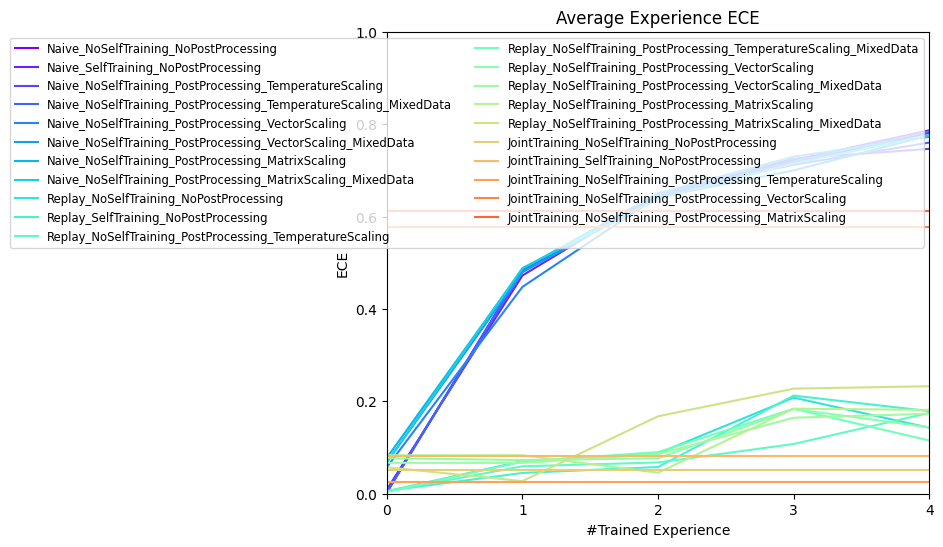

In [7]:
# PLOT 2: Average ece on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(NUM_EXPERIENCES))
color = iter(cm.rainbow(np.linspace(0, 1, 24)))
for i, (name, vals) in enumerate(running_ece):
    c = next(color)
    plt.plot(x_axis, vals, label=run2label[name], color=c)
plt.title('Average Experience ECE')
plt.xlabel('#Trained Experience')
plt.ylabel('ECE')
plt.ylim(0, 1)
plt.xlim(0, NUM_EXPERIENCES-1)
plt.xticks(x_axis, x_axis)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.savefig('Average_Experience_ECE_for_SplitMNIST.eps', format='eps')
plt.show()

In [8]:
# TABLE : average accuracy/ece on all experiences at the end of training

table_data = []
for (n, acc), (_, ece) in zip(final_accuracy, final_ece):
    table_data.append((run2label[n], round(acc, 2), round(ece,2)))

dt = pd.DataFrame(table_data, columns=["RunName", "Accuracy", "ECE"])
print(dt)

                                              RunName  Accuracy   ECE
0               Naive_NoSelfTraining_NoPostProcessing      0.20  0.79
1                 Naive_SelfTraining_NoPostProcessing      0.20  0.78
2   Naive_NoSelfTraining_PostProcessing_Temperatur...      0.20  0.75
3   Naive_NoSelfTraining_PostProcessing_Temperatur...      0.20  0.76
4   Naive_NoSelfTraining_PostProcessing_VectorScaling      0.20  0.78
5   Naive_NoSelfTraining_PostProcessing_VectorScal...      0.20  0.78
6   Naive_NoSelfTraining_PostProcessing_MatrixScaling      0.20  0.77
7   Naive_NoSelfTraining_PostProcessing_MatrixScal...      0.20  0.78
8              Replay_NoSelfTraining_NoPostProcessing      0.59  0.14
9                Replay_SelfTraining_NoPostProcessing      0.74  0.18
10  Replay_NoSelfTraining_PostProcessing_Temperatu...      0.73  0.17
11  Replay_NoSelfTraining_PostProcessing_Temperatu...      0.73  0.12
12  Replay_NoSelfTraining_PostProcessing_VectorSca...      0.66  0.14
13  Replay_NoSelfTra

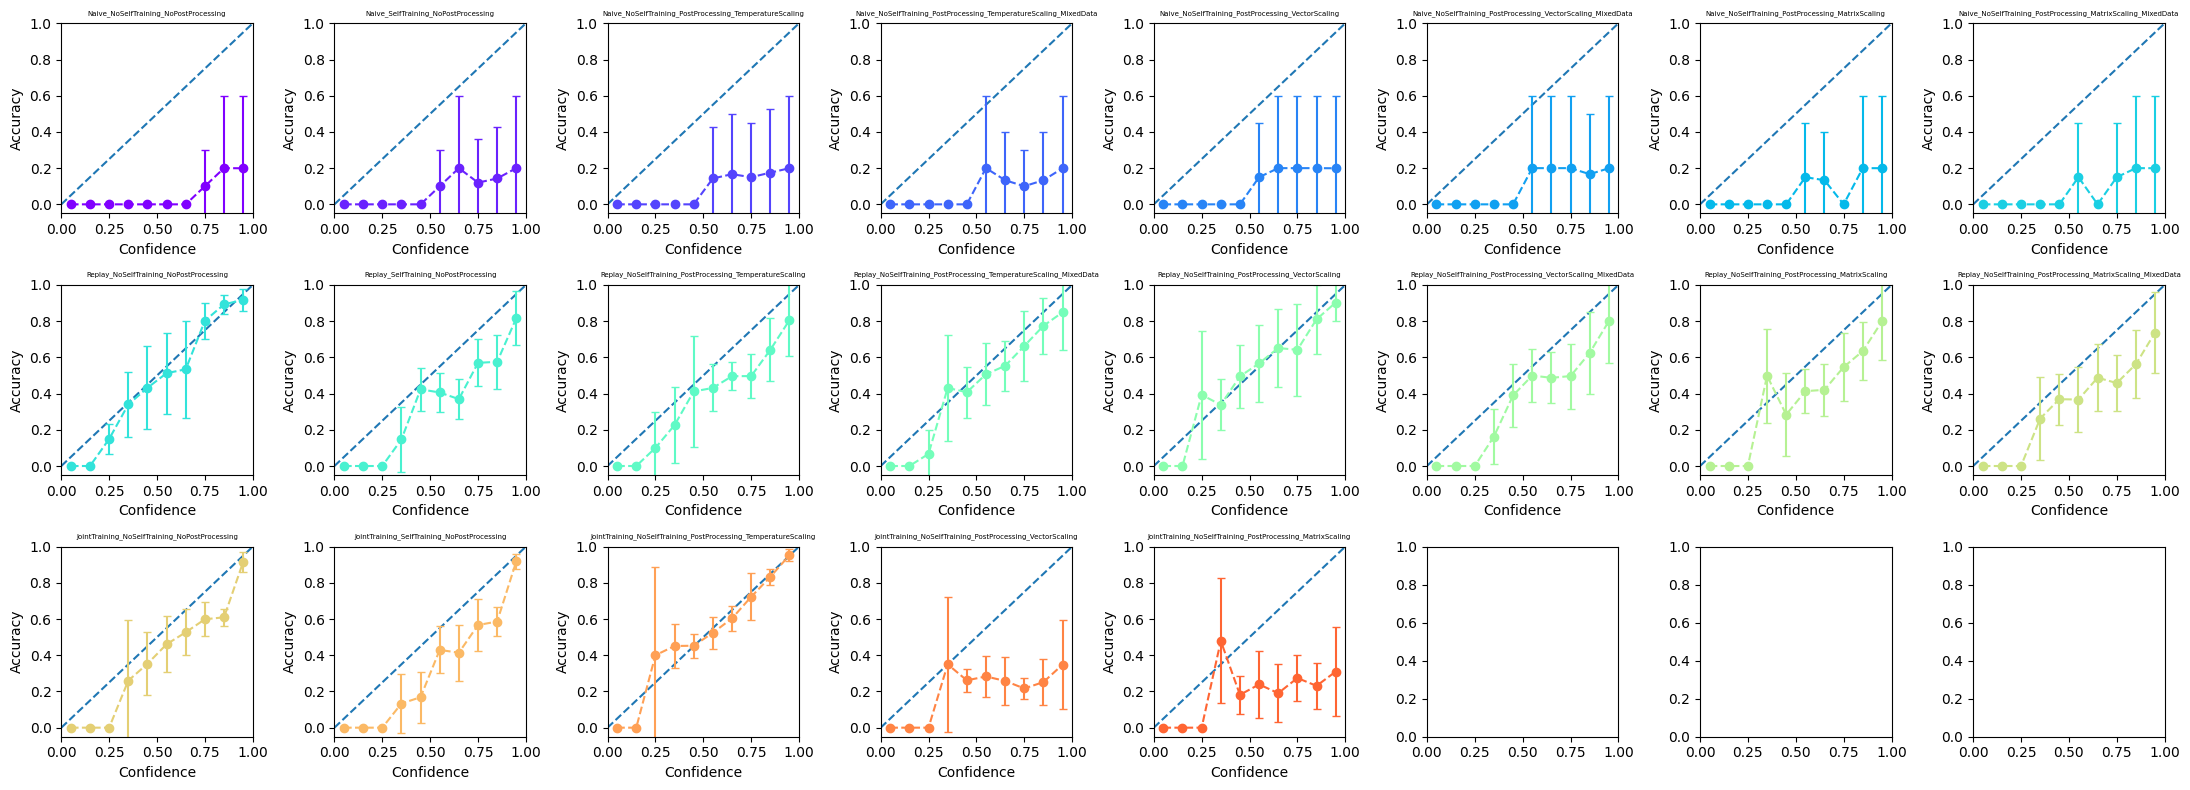

In [9]:
# HISTOGRAM : avg/std across all experiences at the end of training

fig, axs = plt.subplots(3, 8, figsize=(22, 8))
color = iter(cm.rainbow(np.linspace(0, 1, 24)))
axs = axs.flatten()
for i, (name, vals) in enumerate(ece_hist_vals):
    m = [e[0] for e in vals]
    s = [e[1] for e in vals]
    l = [max(e[0] - e[1], 0) for e in vals] # cap lower-bound at zero
    u = [e[0] + e[1] for e in vals]
    c = next(color)
    axs[i].plot([0, 1], [0, 1], '--', label='ideal')
    # axs[i].plot(bins, m, color=valid_colors[i])
    # axs[i].fill_between(bins, l, u, alpha=0.3, linestyle='--', color=valid_colors[i])
    axs[i].errorbar(bins, m, yerr=s, marker="o", linestyle="--", capsize=3, capthick=1, color=c)
    axs[i].set_ylim(-0.05, 1)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylabel("Accuracy")
    axs[i].set_xlabel("Confidence")
    # axs[i].legend(loc='upper left', fontsize='small')
    axs[i].set_title(run2label[name], fontsize='5')
plt.tight_layout()
plt.savefig('Reliability_diagrams_for_SplitMNIST.eps', format='eps')
plt.show()